In [72]:
import pandas as pd
import openpyxl
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np


In [73]:
noc_roma = pd.read_csv("NOC_ROMA_202403110800-202403111600_clusters_la.CSV")

In [74]:
noc_roma

,cluster_id,alarm_id,ne_id,NOTE SPV,domain,network,ne_type,std_probable_cause_no,geo_code,first_occurrence,last_occurrence
0,23801,"EFMTX,65eeac8f89e9530001bd7c5d",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:38,2024-03-11 19:36:19
1,23801,"EFMTX,65eeac8489e9530001bd7c33",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:19
2,23801,"EFMTX,65eeac9089e9530001bd7c6b",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:38,2024-03-11 19:36:25
3,23801,"EFMTX,65eeac8389e9530001bd7c2d",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:19
4,23801,"EFMTX,65eeac8489e9530001bd7c35",romaitbh/ad64/1,CORRELAZIONE OK CLUSTER 23801,tx,sdh,ad64,guasto matrice,roma,2024-03-11 08:02:27,2024-03-11 19:36:25
...,...,...,...,...,...,...,...,...,...,...,...
313,28624,"EFMTX,65ef1d3c6423e50001f2f987",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:03:24,2024-03-11 21:21:52
314,28624,"EFMTX,65ef1d146423e50001f2f954",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:02:43,2024-03-11 19:03:50
315,28624,"EFMTX,65ef1d146423e50001f2f956",romaitdm/adm4/5,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,adm4,loss of pointer lop,roma,2024-03-11 16:02:43,2024-03-11 19:03:50
316,28624,"EFMTX,65ef1bf947128a0001aa8841",romaitde/ad16/3,CORRELAZIONE ERRATA SU CLUSTER 28624,tx,sdh,ad16,loss of pointer lop,roma,2024-03-11 15:58:01,2024-03-11 16:21:39


In [75]:
# 1. Conversione del tempo
noc_roma["first_occurrence"] = pd.to_datetime(noc_roma["first_occurrence"])

# Inizializzare una lista per salvare i risultati
cluster_labels = []
df_list = []

# 2. Raggruppamento per cluster_id e applicazione di DBSCAN
for cluster_id, group in noc_roma.groupby("cluster_id"):
    # Convertire i tempi in numeri
    X = group[["first_occurrence"]].apply(lambda x: x.astype(np.int64) // 10**9).values
    # Applicazione di DBSCAN
    dbscan = DBSCAN(
        eps=500, min_samples=2
    )  # eps è in secondi (86400 secondi = 1 giorno)
    labels = dbscan.fit_predict(X)
    cluster_labels.extend(labels)
    # Creazione di un DataFrame temporaneo con i risultati
    temp_df = pd.DataFrame(
        {
            "cluster_id": cluster_id,
            "alarm_id": group[
                "alarm_id"
            ].values,  # Assumendo che 'alarm_id' sia la colonna con il codice dell'allarme
            "CLUSTER_LABEL": labels,
        }
    )

    # Aggiungere il DataFrame temporaneo alla lista
    df_list.append(temp_df)


# Concatenazione di tutti i DataFrame nella lista in un unico DataFrame
final_df = pd.concat(df_list, ignore_index=True)
filtered_noc_roma = noc_roma[["NOTE SPV"]]

print(final_df)
print("-------------------")
print(filtered_noc_roma)

merge_df = pd.merge(final_df, filtered_noc_roma, left_index=True, right_index=True, how="left")

print(merge_df.columns)
correct_clusters = 0


for _, gruppo in merge_df.groupby("cluster_id"):
    # Controlla se tutti i valori in 'NOTE SVP' sono 'CORRELAZIONE OK'
    if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False).all():
        correct_clusters += 1
# Inizializza il contatore
predicted_clusters = 0

# Raggruppa per 'cluster_id' e itera su ogni gruppo
for _, gruppo in merge_df.groupby("cluster_id"):
    # Controlla se tutti i valori in 'NOTE SVP' sono 'CORRELAZIONE OK'
    if (
        gruppo["CLUSTER_LABEL"].nunique() == 1
        and gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False).all()
    ):
        predicted_clusters += 1


clusters_with_outliers = 0
# Raggruppa per 'cluster_id' e itera su ogni gruppo
for _, gruppo in merge_df.groupby("cluster_id"):
    # Controlla se tutte le 'CLUSTER_LABEL' sono uguali e se c'è almeno un valore -1
    if (
        gruppo["CLUSTER_LABEL"].nunique() == 1
        and (gruppo["CLUSTER_LABEL"] == -1).any()
        and gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False).all()
    ):
        clusters_with_outliers += 1


# Stampa il risultato
print(
    f"Numero di cluster con tutte le NOTE SVP = 'CORRELAZIONE OK': {correct_clusters}"
)
print(
    f"Numero di cluster con un solo cluster_label e tutte le NOTE SVP = 'CORRELAZIONE OK': {predicted_clusters}"
)
print(
    f"Numero di cluster con un solo cluster_label, almeno un outlier e tutte le NOTE SVP = 'CORRELAZIONE OK': {clusters_with_outliers}"
)
# Salvataggio del DataFrame concatenato in un file CSV
merge_df.to_csv("cluster.csv", index=False)
# Salvataggio del DataFrame concatenato in un file Excel
merge_df.to_excel("cluster.xlsx", index=False)

     cluster_id                        alarm_id  CLUSTER_LABEL
0         23801  EFMTX,65eeac8f89e9530001bd7c5d              0
1         23801  EFMTX,65eeac8489e9530001bd7c33              0
2         23801  EFMTX,65eeac9089e9530001bd7c6b              0
3         23801  EFMTX,65eeac8389e9530001bd7c2d              0
4         23801  EFMTX,65eeac8489e9530001bd7c35              0
..          ...                             ...            ...
313       28624  EFMTX,65ef1d3c6423e50001f2f987              0
314       28624  EFMTX,65ef1d146423e50001f2f954              0
315       28624  EFMTX,65ef1d146423e50001f2f956              0
316       28624  EFMTX,65ef1bf947128a0001aa8841              0
317       28624  EFMTX,65ef1d13cd606500014b9506              0

[318 rows x 3 columns]
-------------------
                                 NOTE SPV
0           CORRELAZIONE OK CLUSTER 23801
1           CORRELAZIONE OK CLUSTER 23801
2           CORRELAZIONE OK CLUSTER 23801
3           CORRELAZIONE OK CLUS

In [76]:
merge_df

,cluster_id,alarm_id,CLUSTER_LABEL,NOTE SPV
0,23801,"EFMTX,65eeac8f89e9530001bd7c5d",0,CORRELAZIONE OK CLUSTER 23801
1,23801,"EFMTX,65eeac8489e9530001bd7c33",0,CORRELAZIONE OK CLUSTER 23801
2,23801,"EFMTX,65eeac9089e9530001bd7c6b",0,CORRELAZIONE OK CLUSTER 23801
3,23801,"EFMTX,65eeac8389e9530001bd7c2d",0,CORRELAZIONE OK CLUSTER 23801
4,23801,"EFMTX,65eeac8489e9530001bd7c35",0,CORRELAZIONE OK CLUSTER 23801
...,...,...,...,...
313,28624,"EFMTX,65ef1d3c6423e50001f2f987",0,CORRELAZIONE ERRATA SU CLUSTER 28624
314,28624,"EFMTX,65ef1d146423e50001f2f954",0,CORRELAZIONE ERRATA SU CLUSTER 28624
315,28624,"EFMTX,65ef1d146423e50001f2f956",0,CORRELAZIONE ERRATA SU CLUSTER 28624
316,28624,"EFMTX,65ef1bf947128a0001aa8841",0,CORRELAZIONE ERRATA SU CLUSTER 28624


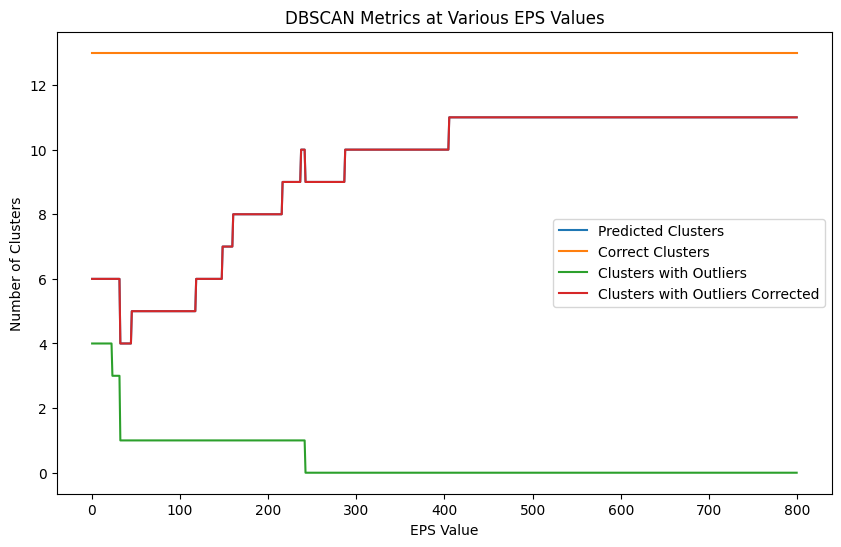

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

# Assumiamo che noc_roma sia già definito e preparato come nel frammento di codice fornito

# 1. Definire un intervallo di valori per eps
eps_values = np.arange(0.5, 800, 1)  # Da 50 a 950 con incrementi di 50

# 2. Inizializzare le liste per memorizzare i valori delle metriche
predicted_clusters_list = []
correct_clusters_list = []
clusters_with_outliers_list = []
cluster_correct_2_list = []

# 3. Iterare su ogni valore di eps
for eps in eps_values:
    predicted_clusters = 0
    correct_clusters = 0
    clusters_with_outliers = 0
    cluster_correct_2 = 0
    df_list = []

    for cluster_id, group in noc_roma.groupby("cluster_id"):
        # Convertire i tempi in numeri
        X = group[["first_occurrence"]].apply(lambda x: x.astype(np.int64) // 10**9).values
        # Applicazione di DBSCAN con il valore corrente di eps
        dbscan = DBSCAN(eps=eps, min_samples=2)
        labels = dbscan.fit_predict(X)
        
        temp_df = pd.DataFrame({
            "cluster_id": cluster_id,
            "alarm_id": group["alarm_id"].values,
            "CLUSTER_LABEL": labels,
        })
        df_list.append(temp_df)

    final_df = pd.concat(df_list, ignore_index=True)
    merge_df = pd.merge(final_df, noc_roma[["cluster_id", "NOTE SPV"]], on="cluster_id", how="left")

    for _, gruppo in merge_df.groupby("cluster_id"):
        if gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False).all():
            correct_clusters += 1
        if gruppo["CLUSTER_LABEL"].nunique() == 1 and gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False).all():
            predicted_clusters += 1
        if gruppo["CLUSTER_LABEL"].nunique() == 1 and (gruppo["CLUSTER_LABEL"] == -1).any() and gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False).all():
            clusters_with_outliers += 1
            
            # Filtra le righe con CORRELAZIONE OK
        gruppo_correlazione_ok = gruppo[gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False)]
        # Filtra le righe senza CORRELAZIONE OK
        gruppo_no_correlazione = gruppo[~gruppo["NOTE SPV"].str.contains("CORRELAZIONE OK", na=False)]
        
        # Controlla se esiste un unico CLUSTER_LABEL per le righe con CORRELAZIONE OK
        if gruppo_correlazione_ok["CLUSTER_LABEL"].nunique() == 1:
            # Ottiene il CLUSTER_LABEL unico per CORRELAZIONE OK
            label_correlazione_ok = gruppo_correlazione_ok["CLUSTER_LABEL"].iloc[0]
            
            # Verifica che le righe senza CORRELAZIONE OK abbiano tutte un CLUSTER_LABEL diverso
            # da quello delle righe con CORRELAZIONE OK (se presenti)
            if gruppo_no_correlazione.empty or not (gruppo_no_correlazione["CLUSTER_LABEL"] == label_correlazione_ok).any():
                cluster_correct_2 += 1
        

    # 5. Salvare i risultati nelle liste
    predicted_clusters_list.append(predicted_clusters)
    correct_clusters_list.append(correct_clusters)
    clusters_with_outliers_list.append(clusters_with_outliers)
    cluster_correct_2_list.append(cluster_correct_2)

# 6. Tracciare il grafico
plt.figure(figsize=(10, 6))
plt.plot(eps_values, predicted_clusters_list, label='Predicted Clusters')
plt.plot(eps_values, correct_clusters_list, label='Correct Clusters')
plt.plot(eps_values, clusters_with_outliers_list, label='Clusters with Outliers')
plt.plot(eps_values, cluster_correct_2_list, label='Clusters correct 2')
plt.xlabel('EPS Value')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN Metrics at Various EPS Values')
plt.legend()
plt.show()